word2vec是将语言中的字词转化为计算机可以理解的稠密向量(Dense Vector),进而可以做其他自然语言处理任务，比如文本分类、词性标注、机器翻译等

Word2Vec也称Word Embedding,中文也有很多叫法，比如词向量或词嵌入。Word2Vec是一个可以将语言中字词转化为向量形式表达的模型，我们先来看看为什么要把字词转为向量。

在Word2Vec出现之前，自然语言处理通常将字词转成离散的单独的符号，如词袋模型，使用的独热编码技术。

**向量空间模型可以将字词转为连续值(相对于独热编码的离散值)的向量表达，并且其中意思相近的词将被映射到向量空间中相近的位置。**

向量空间模型的假设前提是:Distributional Hypothesis,即在相同语境中出现的词其语义也相近。

向量空间模型大致分成两类，一类是计数模型，比如Latent Semantic Analysis；另一类是预测模型(比如Neural Probabilistic Language Models)。

计数模型统计在语料库中，相邻出现的词的频率，再把这些计数统计结果转为小而稠密的矩阵；而预测模型则根据一个词周围相邻的词推测出这个词，以及它的空间向量。

Word2vec 是一种计算非常高效的，可以从原始语料中学习字词空间向量的预测模型。它主要分为CBOW和Skip-Gram两种模式，其中CBOW是从原始语句推测目标字词，

而skip-gram则正好相反，它是从目标字词推测出原始语句。其中CBOW对小型数据比较合适，而Skip-Gram在大型语料中表现得更好。

**这里我们主要使用skip-gram模式的word2vec**

In [0]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import urllib3.request
from urllib import urlretrieve
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
#从网络下载数据
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url+filename, filename)
  statinfo = os.stat(filename)
  
  if statinfo.st_size == expected_bytes:
    print('Found and Verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify '+filename+'. Can you get to it with a browser?')
    
  return filename

filename = maybe_download('text8.zip', 31344016)

('Found and Verified', 'text8.zip')


In [3]:
#解压下载的压缩文件，并使用tf.compat.as_str将数据转成单词的列表
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    
  return data

words = read_data(filename)
print('Data size', len(words))

('Data size', 17005207)


In [0]:
vocabulary_size = 50000
#创建词汇表
def build_dataset(words):
  count = [['UNK',-1]]
  #统计单词列表中单词的频数，然后使用most_common方法提取top 50000频数的单词作为词汇表
  count.extend(collections.Counter(words).most_common(vocabulary_size-1)) 
  #将top 50000词汇的vocabulary放入dictionary中，以便快速查询，时间复杂度为O(1)
  dictionary = dict()#词汇表
  for word, _ in count:
    dictionary[word] = len(dictionary) #使用当前的字典长度作为索引号
    
  data = list() #字典对应的编码列表
  unk_count = 0
  
  #将所有的单词转成索引编号
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0
      unk_count += 1
    data.append(index)
    
  count[0][1] = unk_count #top 50000单词的频数统计以及其他unk词的统计
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))#词典的反转形式
  
  return data, count, dictionary, reverse_dictionary

data,count,dictionary,reverse_dictionary = build_dataset(words)

In [5]:
del words #删除原始单词列表，可以节省内存

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10],[reverse_dictionary[i] for i in data[:10]])

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156], ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against'])


In [0]:
#生成Word2Vec训练样本，根据Skip-Gram模式(从目标单词反推语境)

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  '''
  用来生成训练用的batch数据，skip_window指单词最远可以联系的距离，设为1代表只能跟紧邻的两个单词生成样本
  '''
  global data_index #确保data_index可以在函数generate_batch中被修改
  
  assert batch_size % num_skips==0
  #num_skips是对每个单词生成多少个样本，它不能大于skip_window值得两倍，并且batch_size必须是它的整数倍(确保每个batch包含了一个词汇对应的所有样本)
  assert num_skips<=2 * skip_window 
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  #span为对某个单词创建相关样本时会使用到的单词数量，包括目标单词本身和它前后的单词
  span = 2*skip_window+1
  buffer = collections.deque(maxlen=span) #创建一个双向队列
  
  #从序号data_index开始，把span个单词顺序读入buffer作为初始值。因为buffer是容量为span的deque
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index+1)%len(data)
    
  for i in range(batch_size // num_skips):
    #表示buffer中的第skip_window个单词是目标单词
    target = skip_window
    targets_to_avoid = [skip_window]
    
    
    for j in range(num_skips): #每次循环对一个语境单词生成样本
      
      #while循环是找出一个没有处理过的语境单词
      while target in targets_to_avoid:
        target = random.randint(0, span-1)
      targets_to_avoid.append(target)
      
      batch[i*num_skips+j] = buffer[skip_window] #feature即目标词汇
      labels[i*num_skips+j,0] = buffer[target] #label，即将被预测的词
      
    buffer.append(data[data_index])
    data_index = (data_index+1) % len(data)
  return batch, labels

In [7]:
#在这里简单调用一下generate_batch函数简单测试一下其功能。
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i,0],reverse_dictionary[labels[i,0]])

(3084, 'originated', '->', 5239, 'anarchism')
(3084, 'originated', '->', 12, 'as')
(12, 'as', '->', 3084, 'originated')
(12, 'as', '->', 6, 'a')
(6, 'a', '->', 195, 'term')
(6, 'a', '->', 12, 'as')
(195, 'term', '->', 6, 'a')
(195, 'term', '->', 2, 'of')


In [0]:
batch_size = 128
embedding_size = 128 #将单词转成稠密向量的维度
skip_window = 1
num_skips = 2

valid_size = 16  #用来抽取的验证单词数
valid_window = 100 #指验证单词只从频数最高的100个单词中抽取
valid_examples = np.random.choice(valid_window, valid_size, replace=False) #随机抽取，生成验证数据集
num_sampled = 64 #训练时用来做负样本的噪声单词的数量

In [9]:
# skip-Gram Word2Vec模型的网络结构
graph = tf.Graph() #创建默认的graph
with graph.as_default():
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32) #验证集转为常量集合
  
  with tf.device('/cpu:0'): #限定所有的计算在CPU上执行
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0) #词向量初始化。随机生成所有单词的词向量
    )
  embed = tf.nn.embedding_lookup(embeddings, train_inputs) #查找输入train_inputs对应的向量embed
  
  #初始化损失函数的权重以及偏置
  nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0/math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
  #计算损失函数值，同时使用tf.reduce_mean进行汇总
  loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                    biases=nce_biases,
                                    labels=train_labels,
                                    inputs=embed,
                                    num_sampled=num_sampled,
                                    num_classes=vocabulary_size))
  
  #定义优化器为SGD，且学习率为1.0。
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
  #然后计算嵌入向量embeddings的L2范数norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
  #再将embedding除以其L2范数得到标准化后的normalized_embeddings
  normalized_embeddings = embeddings/norm
  #再使用tf.nn.embedding_lookup查询验证单词的嵌入向量。
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  #计算验证单词的嵌入向量与词汇表中所有单词的相似性。
  similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
  
  #初始化所有模型参数
  init = tf.global_variables_initializer()
  
  #定义最大的迭代次数为10万次
  num_steps = 100001
  
  with tf.Session(graph=graph) as session:
    init.run() #参数初始化
    print('Initialized')
    
    average_loss=0
    for step in range(num_steps):
      batch_inputs,batch_labels = generate_batch(batch_size, num_skips, skip_window) #生成训练样本
      feed_dict = {train_inputs:batch_inputs, train_labels:batch_labels} #创建feed_dict
      
      _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict) #执行一次优化器运算
      average_loss += loss_val #将上一步训练的loss累积到average_loss
      
      #之后每2000次循环，计算一下平均loss并显示出来
      if step % 2000 == 0:
        if step > 0:
          average_loss /= 2000
        print('Average loss at step ', step, ": ", average_loss)
        average_loss = 0
      #每10000次循环，计算一次验证单词与全部单词的相似度，并将与每个验证单词最相似的8个单词展示出来。
      if step%10000 == 0:
        if step > 0:
          average_loss /= 2000
        print('Average loss at step '+str(step)+": "+str(average_loss))
        average_loss = 0
        
      #每10000次循环，计算一次验证单词与全部单词的相似度，并将与每个验证单词最相似的8个单词展示出来。
      if step%10000 == 0:
        sim = similarity.eval()
        for i in range(valid_size):
          valid_word = reverse_dictionary[valid_examples[i]]
          top_k = 8
          nearest = (-sim[i,:]).argsort()[1:top_k+1]
          log_str = 'Nearest to %s:' % valid_word
          for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = '%s %s,'%(log_str, close_word)
          print(log_str)
      final_embeddings = normalized_embeddings.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialized
('Average loss at step ', 0, ': ', 287.8880615234375)
Average loss at step 0: 0
Nearest to were: intruders, russel, planting, entertainments, aire, jakobson, dramatized, yogurt,
Nearest to had: snoopy, conqueror, bowels, mcculloch, recovering, schwann, diploid, sections,
Nearest to is: complicating, invasive, elbing, pcp, parsley, crystallize, nose, brown,
Nearest to on: watch, superscription, bujold, gypsies, wojciech, themselves, ken, presheaf,
Nearest to UNK: tartan, unacceptable, joined, ingeborg, stability, ksc, infects, heavier,
Nearest to also: amathus, mamoru, warr, slogans, vice, refutes, phillies, masonry,
Nearest to state: awe, cement, polycarbonate, calif, pe, pipelines, fool, cga,
Nearest to i: instructed, raft, demonstrated, prostaglandins, hydrosphere, academically, fatah, infinitesimal,
Nearest to only: gentoo, establishment, item, reestablishment, silvanus, simmered, hannibal, misprono

('Average loss at step ', 42000, ': ', 5.321797031521797)
('Average loss at step ', 44000, ': ', 5.289713082313537)
('Average loss at step ', 46000, ': ', 5.251994339227676)
('Average loss at step ', 48000, ': ', 5.039958044886589)
('Average loss at step ', 50000, ': ', 5.1506265014410015)
Average loss at step 50000: 0
Nearest to were: are, was, have, is, had, by, phi, be,
Nearest to had: has, have, was, were, schwann, corgi, blocker, is,
Nearest to is: was, are, has, were, phi, eight, be, dasyprocta,
Nearest to on: in, at, during, from, hewson, and, two, solved,
Nearest to UNK: agouti, dasyprocta, five, imran, victoriae, reginae, thibetanus, amo,
Nearest to also: which, not, often, never, still, gland, it, that,
Nearest to state: awe, cement, cc, agouti, agave, victoriae, agha, condom,
Nearest to i: instructed, ii, we, demonstrated, thibetanus, UNK, no, prism,
Nearest to only: but, item, agave, phi, infertile, condition, it, foul,
Nearest to will: can, could, would, to, may, absorptio

('Average loss at step ', 94000, ': ', 4.62750339114666)
('Average loss at step ', 96000, ': ', 4.72407899594307)
('Average loss at step ', 98000, ': ', 4.606102724969387)
('Average loss at step ', 100000, ': ', 4.678401988983154)
Average loss at step 100000: 0
Nearest to were: are, was, have, had, be, is, been, by,
Nearest to had: has, have, was, were, schwann, indistinguishable, is, when,
Nearest to is: was, has, are, became, gaku, phi, clodius, be,
Nearest to on: in, at, during, mico, under, thaler, upon, hewson,
Nearest to UNK: cegep, agouti, thaler, victoriae, dasyprocta, cebus, gaku, imran,
Nearest to also: often, which, still, never, now, kissed, usually, sometimes,
Nearest to state: upanija, agha, cement, agave, cc, condom, agouti, awe,
Nearest to i: ii, we, you, instructed, thaler, UNK, dimensionally, demonstrated,
Nearest to only: but, infertile, agave, cegep, roshan, akita, one, tamarin,
Nearest to will: can, would, could, may, must, to, should, cannot,
Nearest to would: may

In [0]:
#定义一个用来可视化Word2Vec效果的函数。
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18,18))
  for i, label in enumerate(labels):
    x,y = low_dim_embs[i,:]
    plt.scatter(x,y)
    plt.annotate(label,
                xy=(x,y),
                xytext=(5,2),
                textcoords='offset points',
                ha='right',
                va='bottom')
    
    plt.savefig(filename)
    

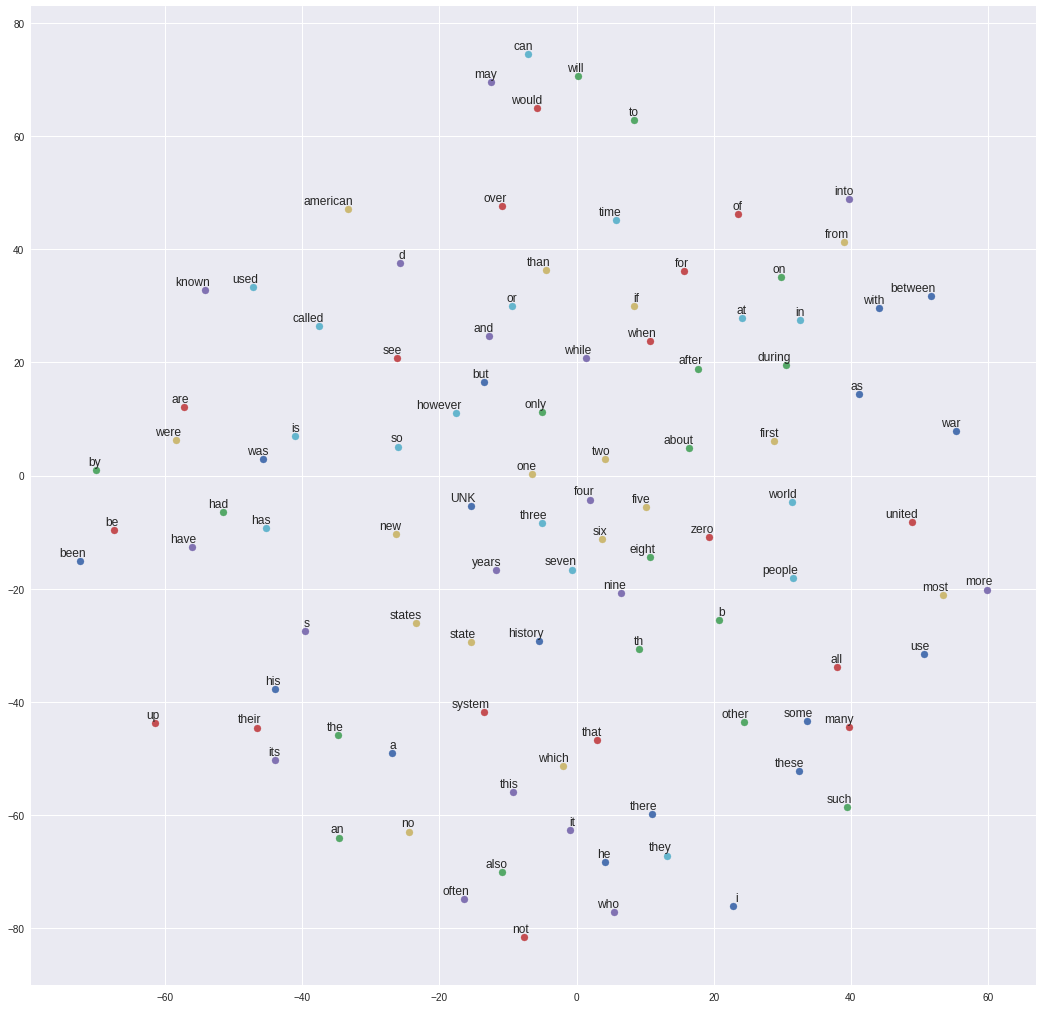

In [11]:
#使用TSNE实现降维，直接将原始128维的嵌入向量降到2维，再用前面的plot_with_labels函数进行展示
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)